In [2]:
import pandas as pd
import json
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.dummy import DummyRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [3]:
def get_accuracy(df):
    accuracy = accuracy_score(df['truth'], df['generated'])
    print(f"Accuracy: {accuracy:.2f}")
    
def get_report(df, output_name, new_cat=True):
    if new_cat:
        report_dict = classification_report(df['truth'], df['generated'], output_dict=True)
        report_df = pd.DataFrame(report_dict).transpose()
        sorted_df = report_df.sort_values(by='f1-score', ascending=False)
        sorted_df.to_csv('results/'+'category_prediction_'+output_name+'_analysis'+'.csv')
    
    else:
        # Filter out rows with all values (excluding 'support') as 0
        filtered_report_df = report_df[report_df.drop('support', axis=1).sum(axis=1) != 0]
        sorted_df = filtered_report_df.sort_values(by='f1-score', ascending=False)
        sorted_df.to_csv('results/'+'category_prediction_'+output_name+'_filtered_analysis'+'.csv')
        
def most_fre_errors(df, show_num=30):
    # Sample data for demonstration
    actual = list(df['truth'])
    predicted = list(df['generated'])
    
    # Compute the confusion matrix
    labels = list(set(actual))
    cm = confusion_matrix(actual, predicted, labels=labels)

    # Convert the confusion matrix to a DataFrame
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    # Extract off-diagonal elements
    wrong_predictions = cm_df.stack().reset_index()
    wrong_predictions.columns = ['Actual', 'Predicted', 'Frequency']
    wrong_predictions = wrong_predictions[wrong_predictions['Actual'] != wrong_predictions['Predicted']]

    # Sort by frequency
    sorted_wrong_predictions = wrong_predictions.sort_values(by='Frequency', ascending=False)
    print(sorted_wrong_predictions.head(show_num))

## Category Prediction

In [4]:
category = pd.read_json('results/category/category_predict_name_des_tip_6711.json').T
category.generated = category.generated.str.split('<').str[0].str.strip().str.strip('.')

In [5]:
get_accuracy(category)

Accuracy: 0.58


In [6]:
category_corrected = pd.read_json('results/category/category_predict_name_des_tip_corrected_6711.json').T
category_corrected.generated = category_corrected.generated.str.split('<').str[0].str.strip().str.strip('.')

In [7]:
get_accuracy(category_corrected)

Accuracy: 0.65


In [8]:
most_fre_errors(category_corrected, show_num=10)

                     Actual           Predicted  Frequency
5549                    Bar          Restaurant        106
16329                Office  Miscellaneous Shop         79
3226         Subway Station       Train Station         64
12449         Deli & Bodega          Restaurant         48
11207           Coffee Shop          Restaurant         44
4042             Restaurant                 Bar         42
12520         Deli & Bodega       Grocery Store         39
17193            Donut Shop         Coffee Shop         27
12485         Deli & Bodega   Convenience Store         24
617    Drugstore & Pharmacy   Convenience Store         23


In [9]:
category_corrected2 = pd.read_json('results/category/category_predict_name_des_tip_corrected_2_6711.json').T
category_corrected2.generated = category_corrected2.generated.str.split('<').str[0].str.strip().str.strip('.')

In [10]:
get_accuracy(category_corrected2)

Accuracy: 0.65


## Rating Prediction

In [138]:
rating_few_shot = pd.read_json('results/rating/rating_predict_3300.json').T
rating_lora = pd.read_json('results/rating/rating_predict_name_des_cate_price_review_epoch16.json')
rating_lora_v2 = pd.read_json('results/rating/rating_predict_name_des_cate_price_review_v2_epoch8.json')

In [139]:
rating_few_shot.generated = rating_few_shot.generated.str[:3]
rating_lora.generated = rating_lora.generated.str[:3]
rating_lora_v2.generated = rating_lora_v2.generated.str[:3]

rating_few_shot['generated'] = pd.to_numeric(rating_few_shot['generated'], errors='coerce')
rating_few_shot = rating_few_shot.dropna()
rating_lora['generated'] = pd.to_numeric(rating_lora['generated'], errors='coerce')
rating_lora = rating_lora.dropna()
rating_lora_v2['generated'] = pd.to_numeric(rating_lora_v2['generated'], errors='coerce')
rating_lora_v2 = rating_lora_v2.dropna()

In [140]:
# Compute regression metrics
rating_few_shot_metrics = [mean_absolute_error(rating_few_shot['truth'], rating_few_shot['generated']), 
                         mean_squared_error(rating_few_shot['truth'], rating_few_shot['generated']),
                         r2_score(rating_few_shot['truth'], rating_few_shot['generated'])]

rating_lora_metrics = [mean_absolute_error(rating_lora['truth'], rating_lora['generated']), 
                       mean_squared_error(rating_lora['truth'], rating_lora['generated']),
                       r2_score(rating_lora['truth'], rating_lora['generated'])]

rating_lora_metrics_v2 = [mean_absolute_error(rating_lora_v2['truth'], rating_lora_v2['generated']), 
                       mean_squared_error(rating_lora_v2['truth'], rating_lora_v2['generated']),
                       r2_score(rating_lora_v2['truth'], rating_lora_v2['generated'])]

mean = rating_lora.truth.mean()
median = rating_lora.truth.median()
length = len(rating_lora)

median_metrics = [mean_absolute_error(rating_lora['truth'], [median]*length), 
                       mean_squared_error(rating_lora['truth'], [median]*length),
                       r2_score(rating_lora['truth'], [median]*length)]

mean_metrics = [mean_absolute_error(rating_lora['truth'], [mean]*length), 
                       mean_squared_error(rating_lora['truth'], [mean]*length),
                       r2_score(rating_lora['truth'], [mean]*length)]

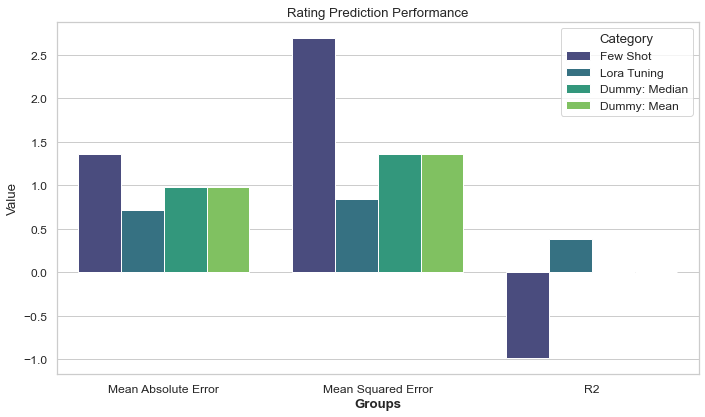

In [141]:
labels = ['Mean Absolute Error', 'Mean Squared Error', 'R2']

# Convert data to DataFrame for Seaborn plotting
df = pd.DataFrame({'Labels': labels*4,
                   'Value': rating_few_shot_metrics+rating_lora_metrics+median_metrics+mean_metrics,
                   'Category': ['Few Shot']*3 + ['Lora Tuning']*3 + ['Dummy: Median']*3 + ['Dummy: Mean']*3})

# Set style and context to make the plot prettier
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)

# Create the plot
plt.figure(figsize=(10,6))
sns.barplot(x='Labels', y='Value', hue='Category', data=df, palette="viridis")

# Adding labels and title
plt.xlabel('Groups', fontweight='bold')
plt.ylabel('Value')
plt.title('Rating Prediction Performance')
plt.legend(title='Category')

# Display the plot
plt.tight_layout()
plt.show()

## Price

In [142]:
price_few_shot = pd.read_json('data/price_predict_700.json').T
price_lora = pd.read_json('results/price/price_predict_name_des_cate.json')
price_lora_v2 = pd.read_json('results/price/price_predict_name_des_cate_v2_epoch8.json')

In [143]:
price_few_shot.generated = price_few_shot.generated.str[:-6]

#df_price.generated.value_counts()
def conversion(price):
    if price == 'Cheap':
        return 1
    elif price == 'Moderate':
        return 2
    elif price == 'Expensive':
        return 3
    elif price == 'Very Expensive':
        return 4
    else:
        return 0
    
price_few_shot.generated = price_few_shot.generated.apply(conversion)

In [144]:
price_few_shot_metrics = [mean_absolute_error(price_few_shot['truth'], price_few_shot['generated']), 
                         mean_squared_error(price_few_shot['truth'], price_few_shot['generated']),
                         r2_score(price_few_shot['truth'], price_few_shot['generated'])]

price_lora_metrics = [mean_absolute_error(price_lora['truth'], price_lora['generated']), 
                       mean_squared_error(price_lora['truth'], price_lora['generated']),
                       r2_score(price_lora['truth'], price_lora['generated'])]

price_lora_metrics_v2 = [mean_absolute_error(price_lora_v2['truth'], price_lora_v2['generated']), 
                       mean_squared_error(price_lora_v2['truth'], price_lora_v2['generated']),
                       r2_score(price_lora_v2['truth'], price_lora_v2['generated'])]

mode = price_lora.truth.mode()
median = price_lora.truth.median()
length = len(price_lora)

median_metrics = [mean_absolute_error(price_lora['truth'], [median]*length), 
                       mean_squared_error(price_lora['truth'], [median]*length),
                       r2_score(price_lora['truth'], [median]*length)]

mode_metrics = [mean_absolute_error(price_lora['truth'], [mode]*length), 
                       mean_squared_error(price_lora['truth'], [mode]*length),
                       r2_score(price_lora['truth'], [mode]*length)]

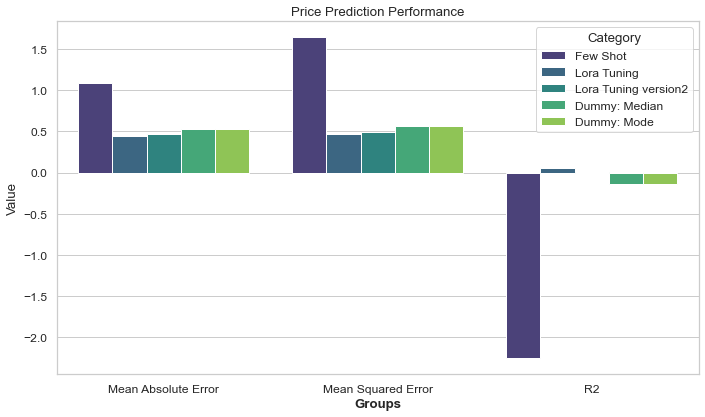

In [145]:
labels = ['Mean Absolute Error', 'Mean Squared Error', 'R2']

# Convert data to DataFrame for Seaborn plotting
df = pd.DataFrame({'Labels': labels*5,
                   'Value': price_few_shot_metrics+price_lora_metrics+price_lora_metrics_v2+median_metrics+mode_metrics,
                   'Category': ['Few Shot']*3 + ['Lora Tuning']*3 + ['Lora Tuning version2']*3 + ['Dummy: Median']*3 + ['Dummy: Mode']*3})

# Set style and context to make the plot prettier
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)

# Create the plot
plt.figure(figsize=(10,6))
sns.barplot(x='Labels', y='Value', hue='Category', data=df, palette="viridis")

# Adding labels and title
plt.xlabel('Groups', fontweight='bold')
plt.ylabel('Value')
plt.title('Price Prediction Performance')
plt.legend(title='Category')

# Display the plot
plt.tight_layout()
plt.show()

In [22]:
accuracy_lora = accuracy_score(price_lora['generated'], price_lora['truth'])
print(f"Lora Accuracy: {accuracy_lora:.2f}")

accuracy_few_shot = accuracy_score(price_few_shot['generated'].astype(str), price_few_shot['truth'].astype(str))
print(f"Few Shot Accuracy: {accuracy_few_shot:.2f}")

accuracy_mode = accuracy_score([mode]*length, price_lora['truth'])
print(f"Mode Accuracy: {accuracy_mode:.2f}")

accuracy_median = accuracy_score([median]*length, price_lora['truth'])
print(f"Median Accuracy: {accuracy_median:.2f}")

Lora Accuracy: 0.56
Few Shot Accuracy: 0.17
Mode Accuracy: 0.48
Median Accuracy: 0.48


## Keywords

In [46]:
def overlap_coefficient(setA, setB):
    """
    Calculate the Overlap Coefficient of two sets.
    
    Args:
    - setA (set): First set of items.
    - setB (set): Second set of items.
    
    Returns:
    - float: Overlap Coefficient of the two sets.
    """
    intersection = len(setA.intersection(setB))
    return intersection / min(len(setA), len(setB))

In [47]:
keywords_few_shot = pd.read_json('results/keywords/keywords_predict_name_des_tip_2300.json').T

In [48]:
labels = list(keywords_few_shot['truth'])
labels = [venue.split(',') for venue in labels]
labels = [[word.strip() for word in venue] for venue in labels]

predictions = list(keywords_few_shot['generated'])
predictions = [venue.replace('</s>', '').replace('.', '').split(',') for venue in predictions]
predictions = [[word.strip() for word in venue] for venue in predictions]

In [59]:
average_length_labels = sum(len(inner_list) for inner_list in labels) / len(labels)
print('average number of keywords (true) = ' + str(average_length_labels))

average_length_predictions = sum(len(inner_list) for inner_list in predictions) / len(predictions)
print('average number of keywords (predict) = ' + str(average_length_predictions))

average number of keywords (true) = 23.418695652173913
average number of keywords (predict) = 31.409130434782607


In [64]:
labels_length = [len(inner_list) for inner_list in labels]
predictions_length = [len(inner_list) for inner_list in predictions]

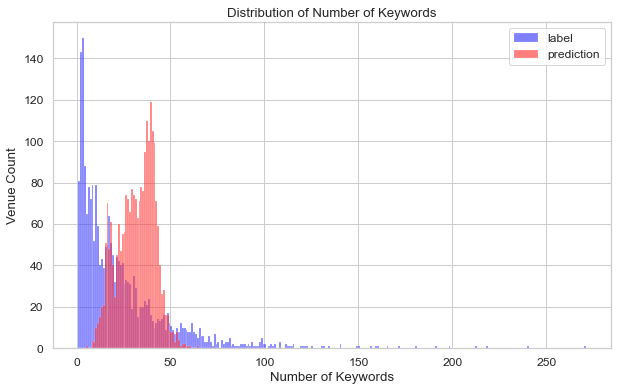

In [109]:
plt.figure(figsize=(10,6))
sns.histplot(labels_length, bins=range(min(labels_length), max(labels_length) + 2), color='blue', alpha=0.5, label='label')
sns.histplot(predictions_length, bins=range(min(predictions_length), max(predictions_length) + 2), color='red', alpha=0.5, label='prediction')
plt.title('Distribution of Number of Keywords')
plt.xlabel('Number of Keywords')
plt.ylabel('Venue Count')
plt.legend()
plt.show()

In [94]:
intersections = []
jaccards = []
cosines = []
overlaps = []

for i in range(len(labels)):
    intersection = set(labels[i]).intersection(set(predictions[i]))
    #jaccard = jaccard_score(set(labels[i]), (set(predictions[i])))
    
    all_unique_elements = set(labels[i]).union(set(predictions[i]))
    
    vector1 = np.array([1 if element in set(labels[i]) else 0 for element in all_unique_elements])
    vector2 = np.array([1 if element in set(predictions[i]) else 0 for element in all_unique_elements])
    
    cosine = cosine_similarity([vector1], [vector2])
    overlap = overlap_coefficient(set(labels[i]), (set(predictions[i])))
    
    intersections.append(len(intersection))
    #jaccards.append(jaccard)
    cosines.append(cosine[0][0])
    overlaps.append(overlap)

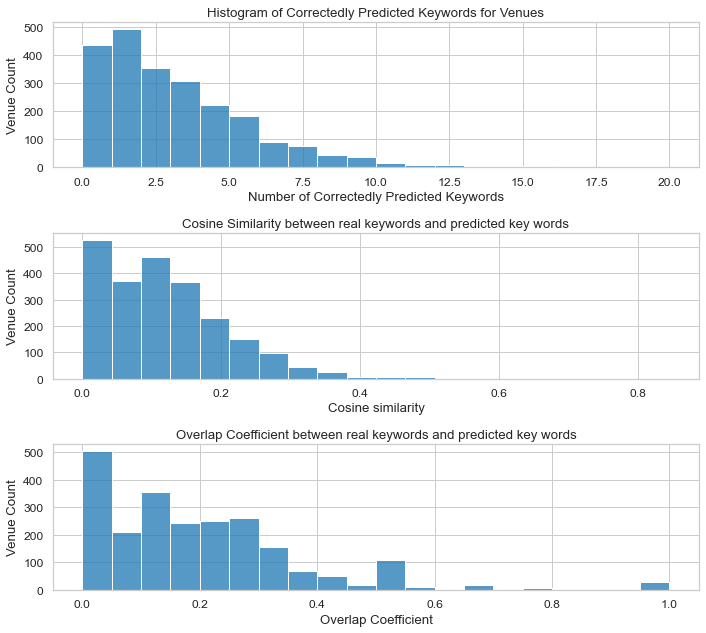

In [171]:
# Create a figure with 3 subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 9))

# Histogram of Correctedly Predicted Keywords for Venues
sns.histplot(intersections, bins=range(min(intersections), max(intersections) + 2), palette="viridis", ax=axes[0])
axes[0].set_title('Histogram of Correctedly Predicted Keywords for Venues')
axes[0].set_xlabel('Number of Correctedly Predicted Keywords')
axes[0].set_ylabel('Venue Count')

# Cosine Similarity between real keywords and predicted key words
sns.histplot(cosines, bins=20, palette="viridis", ax=axes[1])
axes[1].set_title('Cosine Similarity between real keywords and predicted key words')
axes[1].set_xlabel('Cosine similarity')
axes[1].set_ylabel('Venue Count')

# Overlap Coefficient between real keywords and predicted key words
sns.histplot(overlaps, bins=20, palette="viridis", ax=axes[2])
axes[2].set_title('Overlap Coefficient between real keywords and predicted key words')
axes[2].set_xlabel('Overlap Coefficient')
axes[2].set_ylabel('Venue Count')

# Adjust layout
plt.tight_layout()
plt.show()

## Hour

In [82]:
import re
from datetime import datetime, timedelta

def parse_time(time_str):
    """Parse a time string e.g. '11:30 AM' into a datetime object."""
    return datetime.strptime(time_str, '%I:%M %p')

def calculate_iou(label_start, label_end, pred_start, pred_end):
    intersection_start = max(label_start, pred_start)
    intersection_end = min(label_end, pred_end)
    if intersection_end <= intersection_start:
        return 0  # No overlap
    intersection = (intersection_end - intersection_start).total_seconds()

    union_start = min(label_start, pred_start)
    union_end = max(label_end, pred_end)
    union = (union_end - union_start).total_seconds()

    iou = intersection / union
    return iou

def parse_schedule(schedule_str):
    """Parse a weekly schedule string into a dictionary with days as keys and tuples of datetime objects as values."""
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    schedule = {}
    # Define a regex pattern to match valid time formats (e.g. '11:30 AM-10:00 PM')
    time_pattern = re.compile(r'(\d{1,2}:\d{2} [APM]{2})-(\d{1,2}:\d{2} [APM]{2})')

    # Split the schedule string by ';' to separate different day schedules
    day_schedules = schedule_str.split(';')
    for day_schedule in day_schedules:
        day_schedule = day_schedule.strip()
        if 'Daily' in day_schedule:
            times_part = time_pattern.search(day_schedule).group()
            start_time, end_time = [parse_time(time.strip()) for time in times_part.split('-')]
            for day in days:
                schedule[day] = (start_time, end_time)
        else:
            parts = day_schedule.split(' ', 1)
            days_part = parts[0].strip()
            times_part = time_pattern.search(parts[1]).group()
            start_time, end_time = [parse_time(time.strip()) for time in times_part.split('-')]
            if '-' in days_part:
                start_idx = days.index(days_part[:3])
                end_idx = days.index(days_part[-3:])
                for i in range(start_idx, end_idx + 1):
                    schedule[days[i]] = (start_time, end_time)
            else:
                schedule[days_part[:3]] = (start_time, end_time)
    return schedule

In [83]:
hour_lora = pd.read_json('results/open hour/openhour_predict_name_des_cate_pri_fea_tip_epoch10.json')

In [84]:
hour_label = hour_lora['truth'].to_list()
hour_predicted = hour_lora['generated'].to_list()

iou_scores = []
iou_weekdays = []
iou_weekends = []

for i in range(len(hour_label)):
    if hour_label[i] == 'Open Daily 12:00 AM-12:00 AM':
        hour_label[i] = 'Open Daily 12:00 AM-11:59 AM'
    # if '12:00 AM' in hour_label[i]:
    #     hour_label[i] = hour_label[i].replace('12:00 AM', '00:00 AM')
    
    label_parsed = parse_schedule(hour_label[i])
    try:
        if hour_predicted[i].strip('</s>').replace('\n', ' ') =='Open Daily 12:00 AM-12:00 AM':
            predicted_parsed = parse_schedule('Open Daily 12:00 AM-11:59 PM')
        else:
            predicted_parsed = parse_schedule(hour_predicted[i].strip('</s>').replace('\n', ' '))
    except:
        predicted_parsed = parse_schedule("Open Daily 12:00 AM-11:59 PM")
        
    iou_score = []
    for day in ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']:
        label_start, label_end = label_parsed.get(day, (None, None))
        pred_start, pred_end = predicted_parsed.get(day, (None, None))

        # If either interval is missing for the day, we consider IoU as 0
        if not label_start or not pred_start:
            iou = 0
        else:
            iou = calculate_iou(label_start, label_end, pred_start, pred_end)
        iou_score.append(iou)
        # print(f'IoU for {day}: {iou:.2f}')
        
    # Calculate the average IoU over the week
    average_iou = sum(iou_score) / len(iou_score)
    average_iou_weekdays = sum(iou_score[:5]) / 5
    average_iou_weekends = sum(iou_score[5:7]) / 2
    
    iou_scores.append(average_iou)
    #if average_iou < 0.05:
        #print(average_iou)
        #print(hour_label[i])
        #print(hour_predicted[i])
        
    iou_weekdays.append(average_iou_weekdays)
    iou_weekends.append(average_iou_weekends)
    
    # print(f'Average IoU over the week: {average_iou:.2f}')

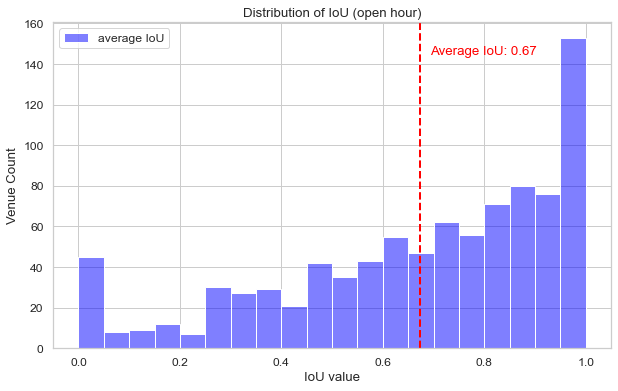

In [89]:
plt.figure(figsize=(10,6))
sns.histplot(iou_scores, bins=20, color='blue', alpha=0.5, label='average IoU')
average_iou = np.mean(iou_scores)
plt.axvline(average_iou, color='red', linestyle='dashed', linewidth=2)
plt.text(average_iou+0.02, plt.ylim()[1]*0.9, f'Average IoU: {average_iou:.2f}', color='red')
plt.title('Distribution of IoU (open hour)')
plt.xlabel('IoU value')
plt.ylabel('Venue Count')
plt.legend()
plt.show()

In [90]:
sum(iou_scores)/len(iou_scores)

0.6729897176495694

#### IoU(IoE): Intersection (Predicted, Label) / Union (Predicted, Label)

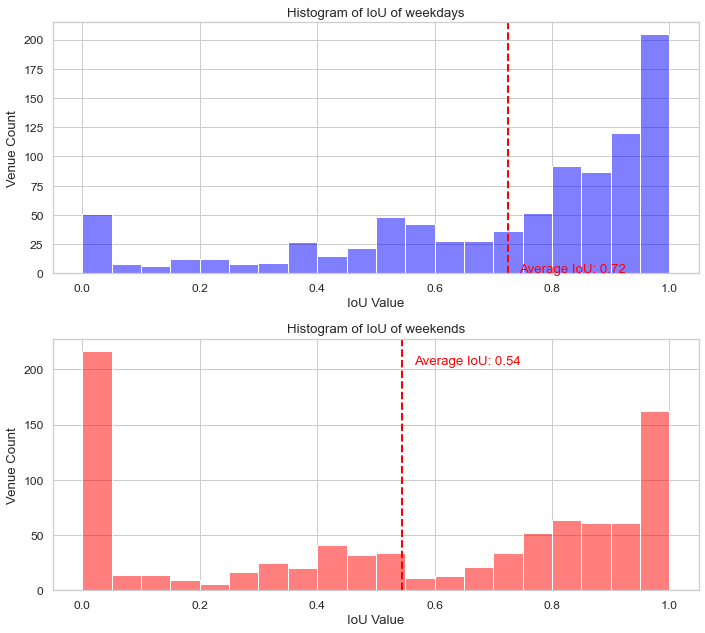

In [95]:
# Create a figure with 3 subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 9))

# Histogram of Correctedly Predicted Keywords for Venues
sns.histplot(iou_weekdays, bins=20, color='blue', alpha=0.5, label='average IoU', ax=axes[0])
axes[0].set_title('Histogram of IoU of weekdays')
axes[0].set_xlabel('IoU Value')
axes[0].set_ylabel('Venue Count')

average_iou_weekdays = np.mean(iou_weekdays)
axes[0].axvline(average_iou_weekdays, color='red', linestyle='dashed', linewidth=2)
axes[0].text(average_iou_weekdays+0.02, plt.ylim()[1]*0.9, f'Average IoU: {average_iou_weekdays:.2f}', color='red')

# Cosine Similarity between real keywords and predicted key words
sns.histplot(iou_weekends, bins=20, color='red', alpha=0.5, label='average IoU')
axes[1].set_title('Histogram of IoU of weekends')
axes[1].set_xlabel('IoU Value')
axes[1].set_ylabel('Venue Count')


average_iou_weekends = np.mean(iou_weekends)
axes[1].axvline(average_iou_weekends, color='red', linestyle='dashed', linewidth=2)
axes[1].text(average_iou_weekends+0.02, plt.ylim()[1]*0.9, f'Average IoU: {average_iou_weekends:.2f}', color='red')

# Adjust layout
plt.tight_layout()
plt.show()

### Popular Hour

In [96]:
popularhour_lora = pd.read_json('results/popular hour/popularhour_predict_name_des_cate_pri_fea_tip_v2.json')

In [97]:
import re
from datetime import datetime, timedelta

def parse_intervals(interval_str):
    """
    Parses the time intervals from a given string into a list of datetime tuples.
    """
    # Remove any incomplete parts at the end of the string
    interval_str = re.sub(r', [A-Za-z]+ \d{2}:\d{2} to$', '', interval_str)

    # Regex to find all intervals
    pattern = r'([A-Za-z]+) (\d{2}:\d{2}) to (([A-Za-z]+) (\d{2}:\d{2})|(\d{2}:\d{2}))'
    matches = re.findall(pattern, interval_str)

    intervals = []
    for match in matches:
        start_day, start_time, _, end_day, end_time, single_end_time = match
        end_time = end_time or single_end_time
        start = datetime.strptime(f'{start_day} {start_time}', '%A %H:%M')
        # If the end day is specified, use it; otherwise, use the start day
        end_day = end_day or start_day
        end = datetime.strptime(f'{end_day} {end_time}', '%A %H:%M')

        # Adjust for intervals that go past midnight
        if end < start:
            end += timedelta(days=1)

        intervals.append((start, end))

    return intervals

def calculate_iou(intervals1, intervals2):
    """
    Calculates the Intersection over Union (IoU) of two sets of time intervals.
    Each hour is considered a unit.
    """
    def get_hours(interval):
        """ Generates a set of hours from a time interval. """
        start, end = interval
        return set(range(int(start.strftime('%w%H')), int(end.strftime('%w%H'))))

    # Get all hours for each set of intervals
    hours1 = set()
    for interval in intervals1:
        hours1.update(get_hours(interval))

    hours2 = set()
    for interval in intervals2:
        hours2.update(get_hours(interval))

    # Calculate Intersection and Union
    intersection = hours1.intersection(hours2)
    union = hours1.union(hours2)

    # IoU calculation
    return len(intersection) / len(union) if union else 0

In [98]:
iou_scores = []

for i in range(len(popular_hour_label)):
    # popular_hour_label[i] = popular_hour_label[i].replace('</s>', '')
    try:
        label_parsed = parse_intervals(popular_hour_label[i].replace('\n', ''))
        schedule_str = popular_hour_predicted[i].strip('</s>').replace('\n', '')
        formatted_schedule_str = re.sub(r',(?!\s)', ', ', schedule_str)
        predicted_parsed = parse_intervals(formatted_schedule_str)
        
        iou_score = calculate_iou(label_parsed, predicted_parsed)
        #print(f"IoU for the entire week: {iou_score:.4f}")
        iou_scores.append(iou_score)
    except:
        continue

#iou_scores *= 30
# print(f'Average IoU over the week: {average_iou:.2f}')

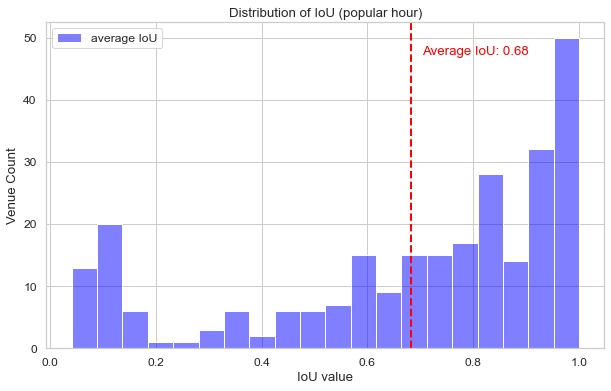

In [100]:
# Plotting the histogram
plt.figure(figsize=(10,6))
sns.histplot(iou_scores, bins=20, color='blue', alpha=0.5, label='average IoU')

# Calculate and show the average value of the IoU scores
average_iou = np.mean(iou_scores)
plt.axvline(average_iou, color='red', linestyle='dashed', linewidth=2)
plt.text(average_iou+0.02, plt.ylim()[1]*0.9, f'Average IoU: {average_iou:.2f}', color='red')

plt.title('Distribution of IoU (popular hour)')
plt.xlabel('IoU value')
plt.ylabel('Venue Count')
plt.legend()
plt.show()


In [124]:
# !pip install sentence_transformers segtok openai
import re
import pandas as pd
import numpy as np
import pickle
import openai
from datetime import datetime

from datetime import datetime
from functools import lru_cache
from itertools import product
from pathlib import Path

from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from segtok.segmenter import split_single

def prepare_model():
    """Load the model."""
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    return model


def split_sentences(text):
    sentences = list(i for i in text if i and len(i) > 0)
    return sentences


def split_chat_corpus(text: str) -> 'list[str]':
    """Split ChatGPT sentences by integer bullet-point prefix."""
    # Split the sentence
    sentences = split_sentences(text)
    # Replace \d+. prefix in the sentence with empty
    sentences = [re.sub(r'^\d+\.', '', i) for i in sentences]
    return sentences



model = prepare_model()



def _generate_similarity_df(model, sentence1, sentence2):
    
    chat_sentences = split_chat_corpus(sentence1)
    wiki_sentences = split_chat_corpus(sentence2)
    wiki_embeddings: np.ndarray = model.encode(wiki_sentences, normalize_embeddings=True)
    chat_embeddings: np.ndarray = model.encode(chat_sentences, normalize_embeddings=True)
    similarity: np.ndarray = cosine_similarity(
        wiki_embeddings,
        chat_embeddings
    )
    similarity = similarity.reshape((
        len(wiki_sentences) * len(chat_sentences),  # rows
        1  # columns
    ))
    return similarity



In [125]:
_generate_similarity_df(model, ['Hello'], ['Hi'])

array([[0.8071529]], dtype=float32)

In [120]:
keywords_few_shot = pd.read_json('results/keywords/keywords_predict_name_des_tip_3200.json').T

In [121]:
predictions = keywords_few_shot['generated'].tolist()
labels = keywords_few_shot['truth'].tolist()

In [130]:
scores = []
for i in range(len(predictions)):
    scores.append(_generate_similarity_df(model, [predictions[i]], [labels[i]]))
    if i % 100 == 0:
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100


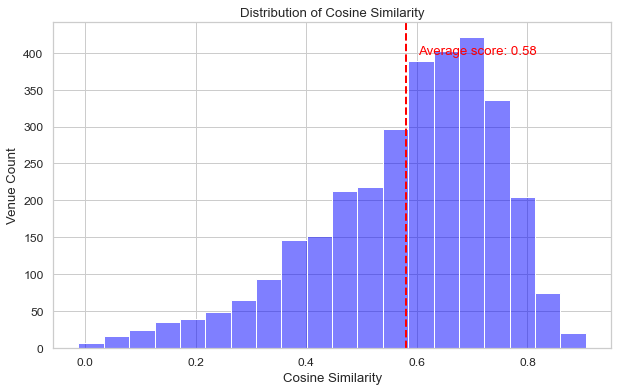

In [147]:
# Plotting the histogram
plt.figure(figsize=(10,6))
sns.histplot(scores, bins=20, color='blue', alpha=0.5, label='Cosine Similarity')

# Calculate and show the average value of the IoU scores
average_iou = np.mean(scores)
plt.axvline(average_iou, color='red', linestyle='dashed', linewidth=2)
plt.text(average_iou+0.02, plt.ylim()[1]*0.9, f'Average score: {average_iou:.2f}', color='red')

plt.title('Distribution of Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Venue Count')
# plt.legend()
plt.show()


In [133]:
scores = [score[0][0] for score in scores]